## LG 18650HG2 Li-ion Battery SOC Prediction - Long Short Term Memory (LSTM)
LG 18650HG2 Li-ion Battery Data - https://data.mendeley.com/datasets/cp3473x7xv/3

Kollmeyer, Philip; Vidal, Carlos; Naguib, Mina; Skells, Michael  (2020), “LG 18650HG2 Li-ion Battery Data and Example Deep Neural Network xEV SOC Estimator Script”, Mendeley Data, V3, doi: 10.17632/cp3473x7xv.3

### LSTM Architecture and Data Processing
This script focuses on creating an LSTM model for estimating the state of charge (SoC) of LG HG2 batteries. It starts by defining necessary libraries and parameters, including a custom dataset class for handling battery data with LSTM. The script loads and processes the data, normalizes it, and splits it into training, validation, and testing sets. An LSTM model class is defined, followed by a training loop with validation.

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

2.1.2+cu121
True
cuda:0


In [102]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna
from torch.profiler import profile, ProfilerActivity
import time 
from torch.cuda.amp import GradScaler, autocast 

# Check if the environment variable is set to 'True'
skip_training = os.getenv('SKIP_TRAINING', 'False') == 'True'
skip_optuna = os.getenv('SKIP_OPTUNA', 'False') == 'True'

PROCESSED_DATA_DIR = '../dataset/LG_HG2_processed'
FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Power [W]', 'CC_Capacity [Ah]']
LABEL_COL = 'SOC [-]'
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 0.0001
SEQUENCE_LENGTH = 20  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Function to load data
def load_data(directory, temperatures):
    frames = []    
    for temp_folder in os.listdir(directory):
        if temp_folder in temperatures:
            temp_path = os.path.join(directory, temp_folder)
            for file in os.listdir(temp_path):
                if 'Charge' in file or 'Dis' in file:
                    continue  # Skip constant charge and discharge files
                if file.endswith('.csv'):
                    df = pd.read_csv(os.path.join(temp_path, file))
                    df['SourceFile'] = file

                    # Calculate power
                    df['Power [W]'] = df['Voltage [V]'] * df['Current [A]']

                    # Initialize CC_Capacity [Ah] column
                    df['CC_Capacity [Ah]'] = 0.0

                    # Integrating current over time to calculate cumulative capacity
                    df['CC_Capacity [Ah]'] = (df['Current [A]'] * df['Time [s]'].diff().fillna(0) / 3600).cumsum()

                    frames.append(df)
    return pd.concat(frames, ignore_index=True)


# Custom dataset class for LSTM
class BatteryDatasetLSTM(Dataset):
    def __init__(self, data_tensor, labels_tensor, sequence_length=50, filenames=None, times=None):
        self.sequence_length = sequence_length
        self.features = data_tensor
        self.labels = labels_tensor
        self.filenames = filenames 
        self.times = times 

    def __len__(self):
        return len(self.features) - self.sequence_length

    def __getitem__(self, idx):
        idx_end = idx + self.sequence_length
        sequence = self.features[idx:idx_end]
        label = self.labels[idx_end - 1]
        filename = self.filenames[idx_end - 1]
        time = self.times[idx_end - 1]  

        sequence = sequence.clone().detach()
        label = label.clone().detach()

        return sequence, label, filename, time
    
    def get_unique_filenames(self):
        return set(self.filenames)
    
    def get_times(self):
        return self.times

# SoCLSTM Model
class SoCLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(SoCLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=x.dtype, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=x.dtype, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Training loop with validation
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, epochs, device, patience=20, min_delta=0.001):
    history = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        total_iterations = len(train_loader)
        epoch_start_time = time.time()
        for sequences, labels, _, _ in train_loader:  
            sequences, labels = sequences.to(device), labels.to(device)
            labels = labels.unsqueeze(1) 
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for sequences, labels, _, _ in val_loader:  
                sequences, labels = sequences.to(device), labels.to(device)
                labels = labels.unsqueeze(1)  
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
        print(f'Time taken for epoch: {epoch_time:.8f} seconds')

        if epochs_no_improve >= patience:
            print('Early stopping triggered')
            # break

    return history

temperatures_to_process = ['25degC', '0degC', 'n10degC', 'n20degC', '10degC', '40degC']   
# temperatures_to_process = ['25degC', '0degC', '10degC'] 
data = load_data(PROCESSED_DATA_DIR, temperatures_to_process)

# Apply a moving average filter to your features
#window_size = 5 
#smoothed_data = data[FEATURE_COLS].rolling(window=window_size, min_periods=1).mean()
# Replace the original features with the smoothed features
#data[FEATURE_COLS] = smoothed_data

scaler = StandardScaler()
data[FEATURE_COLS] = scaler.fit_transform(data[FEATURE_COLS])

unique_files = np.array(list(set(data['SourceFile'])))

# Convert to tensors and load into GPU memory
data_tensor = torch.tensor(data[FEATURE_COLS].values, dtype=torch.float32).to(device)
labels_tensor = torch.tensor(data[LABEL_COL].values, dtype=torch.float32).to(device)
filenames_tensor = data['SourceFile'].values

unique_files = np.array(list(set(data['SourceFile'])))
train_files, temp_files = train_test_split(unique_files, test_size=0.2, random_state=24)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=24)

def filter_data_by_filenames(df, filenames):
    return df[df['SourceFile'].isin(filenames)]

# Filter data for each set
train_data = filter_data_by_filenames(data, train_files)
val_data = filter_data_by_filenames(data, val_files)
test_data = filter_data_by_filenames(data, test_files)


# Convert to tensors
train_tensor = torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device)

val_tensor = torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
val_labels = torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device)

test_tensor = torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device)


# Convert filtered data to tensors and create dataset instances
train_dataset = BatteryDatasetLSTM(
    torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device),
    SEQUENCE_LENGTH,
    train_data['SourceFile'].values,
    train_data['Time [s]'].values  
)

val_dataset = BatteryDatasetLSTM(
    torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device),
    SEQUENCE_LENGTH,
    val_data['SourceFile'].values,
    val_data['Time [s]'].values  
)

test_dataset = BatteryDatasetLSTM(
    torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device),
    SEQUENCE_LENGTH,
    test_data['SourceFile'].values,
    test_data['Time [s]'].values  
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print file names used in training, validation, and testing
train_files = train_dataset.get_unique_filenames()
val_files = val_dataset.get_unique_filenames()
test_files = test_dataset.get_unique_filenames()

train_files_sorted = sorted(train_files)
val_files_sorted = sorted(val_files)
test_files_sorted = sorted(test_files)

print("Training files:", train_files)
print("\nValidation files:", val_files)
print("\nTesting files:", test_files)

Training files: {'576_UDDS_processed.csv', '562_Mixed4_processed.csv', '555_HPPC_processed.csv', '610_Cap_1C_processed.csv', '596_Cap_1C_processed.csv', '552_Mixed4_processed.csv', '551_Mixed1_processed.csv', '590_Mixed4_processed.csv', '567_Mixed1_processed.csv', '556_UDDS_processed.csv', '556_Mixed2_processed.csv', '562_Mixed7_processed.csv', '604_PausCycl_processed.csv', '552_Mixed6_processed.csv', '552_Mixed8_processed.csv', '610_US06_processed.csv', '602_Mixed4_processed.csv', '590_Mixed8_processed.csv', '551_UDDS_processed.csv', '552_Mixed3_processed.csv', '571_PausCycl_processed.csv', '571_Mixed7_processed.csv', '590_Mixed6_processed.csv', '610_LA92_processed.csv', '556_HWFET_processed.csv', '576_HWFET_processed.csv', '604_Mixed6_processed.csv', '571_Mixed8_processed.csv', '607_HPPC_processed.csv', '601_Mixed1_processed.csv', '562_Mixed5_processed.csv', '611_Mixed8_processed.csv', '596_LA92_processed.csv', '589_Mixed2_processed.csv', '549_HPPC_processed.csv', '590_Mixed7_process

In [103]:
print("Train features shape:", train_tensor.shape)
print("Test features shape:", test_tensor .shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train features shape: torch.Size([441453, 5])
Test features shape: torch.Size([49034, 5])
Train labels shape: torch.Size([441453])
Test labels shape: torch.Size([49034])


### Hyperparameter tuning

This segment uses Optuna for LSTM hyperparameter tuning to optimize state-of-charge estimation for batteries. It defines an objective function to suggest hyperparameters like hidden size and number of layers for the LSTM model. The model is trained and validated, focusing on minimizing validation loss. The best hyperparameters are identified from the trials. The script includes visualization of the optimization history and the importance of different hyperparameters, providing insights into the tuning process.

In [97]:
if not skip_optuna:
    # Define Optuna objective function
    def objective(trial):
        # Suggest hyperparameters
        hidden_size = trial.suggest_int('hidden_size', 10, 100)
        num_layers = trial.suggest_int('num_layers', 1, 5)
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)

        # Instantiate model with suggested hyperparameters
        model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers).type(torch.float32).to(device)

        # Define your loss function and optimizer with suggested hyperparameters
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Call your train and validate function
        history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

        # Extract last validation loss
        last_val_loss = history['val_loss'][-1]
        return last_val_loss

    # Optuna study
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=10)

    # Extract best trial
    best_trial = study.best_trial
    print(f"Best trial: {best_trial}")

    best_hyperparams = study.best_trial.params
    print('Best hyperparameters:', best_hyperparams)

    # Visualize the optimization process
    from optuna.visualization import plot_optimization_history, plot_param_importances

    # Plot optimization history
    optimization_history = plot_optimization_history(study)
    optimization_history.show()

    # Plot hyperparameter importance
    param_importances = plot_param_importances(study)
    param_importances.show()

[I 2024-01-22 10:12:20,875] A new study created in memory with name: no-name-4bf4c8dc-f075-42d6-9ee7-7a7348e26868


Epoch 1/10, Train Loss: 0.0007930393599646009, Validation Loss: 0.0001867124624029464
Time taken for epoch: 125.08036089 seconds
Epoch 2/10, Train Loss: 0.0003296897410991602, Validation Loss: 0.0002017267851323384
Time taken for epoch: 153.24602389 seconds
Epoch 3/10, Train Loss: 0.0002980894051018721, Validation Loss: 0.00018817281404884367
Time taken for epoch: 120.79646206 seconds
Epoch 4/10, Train Loss: 0.0002930206322768717, Validation Loss: 0.00031723561604519117
Time taken for epoch: 122.75091410 seconds
Epoch 5/10, Train Loss: 0.00028766703880655586, Validation Loss: 0.00019851910385393806
Time taken for epoch: 147.51449227 seconds
Epoch 6/10, Train Loss: 0.00029355826602309567, Validation Loss: 0.000267827799394307
Time taken for epoch: 141.09597516 seconds
Epoch 7/10, Train Loss: 0.00029071688949932294, Validation Loss: 0.00021194874818580899
Time taken for epoch: 139.24868059 seconds
Epoch 8/10, Train Loss: 0.0002949997818398161, Validation Loss: 0.00033551641436828036
Time

[I 2024-01-22 10:37:47,779] Trial 0 finished with value: 0.0002487515397664555 and parameters: {'hidden_size': 10, 'num_layers': 4, 'learning_rate': 0.032065209933990195}. Best is trial 0 with value: 0.0002487515397664555.


Epoch 1/10, Train Loss: 0.010457844465300268, Validation Loss: 0.00038690093965047703
Time taken for epoch: 370.78794456 seconds
Epoch 2/10, Train Loss: 0.000442873208279207, Validation Loss: 0.0002657005371191888
Time taken for epoch: 268.03373790 seconds
Epoch 3/10, Train Loss: 0.0003422276039684922, Validation Loss: 0.00021714186140926346
Time taken for epoch: 273.38814783 seconds
Epoch 4/10, Train Loss: 0.0003025827299426977, Validation Loss: 0.00020425742241961408
Time taken for epoch: 275.75276136 seconds
Epoch 5/10, Train Loss: 0.0002852012926850375, Validation Loss: 0.0001939310068272812
Time taken for epoch: 274.50702572 seconds
Epoch 6/10, Train Loss: 0.0002732015535046226, Validation Loss: 0.0001904309383442544
Time taken for epoch: 290.65029526 seconds
Epoch 7/10, Train Loss: 0.00026031882068719805, Validation Loss: 0.00018880121124471605
Time taken for epoch: 292.72882700 seconds
Epoch 8/10, Train Loss: 0.00024936628332304, Validation Loss: 0.00020010805084558472
Time take

[I 2024-01-22 11:29:13,921] Trial 1 finished with value: 0.00015358898055249518 and parameters: {'hidden_size': 57, 'num_layers': 5, 'learning_rate': 3.660312030272293e-05}. Best is trial 1 with value: 0.00015358898055249518.


Epoch 10/10, Train Loss: 0.00023056797702220992, Validation Loss: 0.00015358898055249518
Time taken for epoch: 290.52684140 seconds
Epoch 1/10, Train Loss: 0.000579205724389875, Validation Loss: 0.000244923003698894
Time taken for epoch: 196.70031714 seconds
Epoch 2/10, Train Loss: 0.00031543702666592984, Validation Loss: 0.00019495137746653786
Time taken for epoch: 189.72646236 seconds
Epoch 3/10, Train Loss: 0.0002858060743990089, Validation Loss: 0.0001667167736579097
Time taken for epoch: 193.06938267 seconds
Epoch 4/10, Train Loss: 0.0002462878790369243, Validation Loss: 0.00022378244449990748
Time taken for epoch: 210.59975719 seconds
Epoch 5/10, Train Loss: 0.0002238906282917585, Validation Loss: 0.00014354586086228363
Time taken for epoch: 232.09929252 seconds
Epoch 6/10, Train Loss: 0.00020345621067956545, Validation Loss: 0.00017920200324746065
Time taken for epoch: 232.06357026 seconds
Epoch 7/10, Train Loss: 0.00016652060305565863, Validation Loss: 0.0003171960519648778
Tim

[I 2024-01-22 12:07:05,639] Trial 2 finished with value: 0.0004238928122566578 and parameters: {'hidden_size': 89, 'num_layers': 2, 'learning_rate': 0.004242007798342167}. Best is trial 1 with value: 0.00015358898055249518.


Epoch 10/10, Train Loss: 0.0001309357667888345, Validation Loss: 0.0004238928122566578
Time taken for epoch: 216.31395793 seconds
Epoch 1/10, Train Loss: 0.004127647739156063, Validation Loss: 0.0013429456363420783
Time taken for epoch: 233.90621805 seconds
Epoch 2/10, Train Loss: 0.0005198911837820208, Validation Loss: 0.000314857750126503
Time taken for epoch: 214.20153069 seconds
Epoch 3/10, Train Loss: 0.0004793893033644559, Validation Loss: 0.0003519949305612202
Time taken for epoch: 214.10011482 seconds
Epoch 4/10, Train Loss: 0.00044914850266497005, Validation Loss: 0.0002897981182293043
Time taken for epoch: 213.18555880 seconds
Epoch 5/10, Train Loss: 0.0003874560705858807, Validation Loss: 0.000345280495440747
Time taken for epoch: 215.15816665 seconds
Epoch 6/10, Train Loss: 0.00035934529875802197, Validation Loss: 0.0002234287308330442
Time taken for epoch: 214.91238642 seconds
Epoch 7/10, Train Loss: 0.00034331299601238777, Validation Loss: 0.0002255817796418996
Time taken

[I 2024-01-22 12:45:50,229] Trial 3 finished with value: 0.00020565236937146957 and parameters: {'hidden_size': 95, 'num_layers': 2, 'learning_rate': 0.0359039353138405}. Best is trial 1 with value: 0.00015358898055249518.


Epoch 10/10, Train Loss: 0.000333949914228466, Validation Loss: 0.00020565236937146957
Time taken for epoch: 216.03668571 seconds
Epoch 1/10, Train Loss: 0.007415557609092534, Validation Loss: 0.00022103648465804168
Time taken for epoch: 83.14549732 seconds
Epoch 2/10, Train Loss: 0.00029937525269150905, Validation Loss: 0.0002024271959126496
Time taken for epoch: 78.88972592 seconds
Epoch 3/10, Train Loss: 0.00028089695368146864, Validation Loss: 0.00018974182750981412
Time taken for epoch: 77.48849678 seconds
Epoch 4/10, Train Loss: 0.0002697603841399652, Validation Loss: 0.0002306146284878951
Time taken for epoch: 79.04336858 seconds
Epoch 5/10, Train Loss: 0.0002616986824697384, Validation Loss: 0.00019969816699746672
Time taken for epoch: 76.71680164 seconds
Epoch 6/10, Train Loss: 0.0002504382851700242, Validation Loss: 0.00023829091120198693
Time taken for epoch: 78.56690979 seconds
Epoch 7/10, Train Loss: 0.00023289489622380753, Validation Loss: 0.0002281314777864292
Time taken

[I 2024-01-22 13:00:30,512] Trial 4 finished with value: 0.00020431329549598732 and parameters: {'hidden_size': 14, 'num_layers': 1, 'learning_rate': 0.0006853418312943253}. Best is trial 1 with value: 0.00015358898055249518.


Epoch 10/10, Train Loss: 0.00019866671172538952, Validation Loss: 0.00020431329549598732
Time taken for epoch: 76.65420985 seconds
Epoch 1/10, Train Loss: 0.04106038906818304, Validation Loss: 0.0010182226457909073
Time taken for epoch: 124.71845484 seconds
Epoch 2/10, Train Loss: 0.0007433005441115793, Validation Loss: 0.0004457556739984499
Time taken for epoch: 138.27911067 seconds
Epoch 3/10, Train Loss: 0.0005068536622843667, Validation Loss: 0.0003035225136524654
Time taken for epoch: 130.36059213 seconds
Epoch 4/10, Train Loss: 0.000411707523009079, Validation Loss: 0.00026364436169991584
Time taken for epoch: 130.74847198 seconds
Epoch 5/10, Train Loss: 0.00036291820038185515, Validation Loss: 0.00024375158035660224
Time taken for epoch: 131.41121888 seconds
Epoch 6/10, Train Loss: 0.0003346844975839122, Validation Loss: 0.00022937337212800915
Time taken for epoch: 134.16902232 seconds
Epoch 7/10, Train Loss: 0.0003174806165265568, Validation Loss: 0.0002210710829810117
Time tak

[I 2024-01-22 13:22:43,890] Trial 5 finished with value: 0.00020975321025574993 and parameters: {'hidden_size': 38, 'num_layers': 3, 'learning_rate': 1.8220316145535242e-05}. Best is trial 1 with value: 0.00015358898055249518.


Epoch 10/10, Train Loss: 0.00029147905639655987, Validation Loss: 0.00020975321025574993
Time taken for epoch: 97.78947425 seconds
Epoch 1/10, Train Loss: 0.01101601218916929, Validation Loss: 0.00029778354129758
Time taken for epoch: 91.86503434 seconds
Epoch 2/10, Train Loss: 0.0003604579467243929, Validation Loss: 0.0002070054933673031
Time taken for epoch: 89.78446674 seconds
Epoch 3/10, Train Loss: 0.0002981368835458828, Validation Loss: 0.00020084003517792953
Time taken for epoch: 82.48127747 seconds
Epoch 4/10, Train Loss: 0.000282449209298392, Validation Loss: 0.00020153272142976638
Time taken for epoch: 80.60735559 seconds
Epoch 5/10, Train Loss: 0.00026981134663379904, Validation Loss: 0.0001819409748203281
Time taken for epoch: 88.98412108 seconds
Epoch 6/10, Train Loss: 0.00025073586165659815, Validation Loss: 0.00020552885442379117
Time taken for epoch: 79.58067513 seconds
Epoch 7/10, Train Loss: 0.00022523956602421195, Validation Loss: 0.00018142491697547877
Time taken fo

[I 2024-01-22 13:38:21,496] Trial 6 finished with value: 0.00017441148961460244 and parameters: {'hidden_size': 27, 'num_layers': 3, 'learning_rate': 0.0001777286854278843}. Best is trial 1 with value: 0.00015358898055249518.


Epoch 10/10, Train Loss: 0.00018713418258358105, Validation Loss: 0.00017441148961460244
Time taken for epoch: 87.10746574 seconds
Epoch 1/10, Train Loss: 0.012800137269071392, Validation Loss: 0.00030905353896761516
Time taken for epoch: 80.01677775 seconds
Epoch 2/10, Train Loss: 0.0003873617721246457, Validation Loss: 0.00024281349207708186
Time taken for epoch: 80.60539007 seconds
Epoch 3/10, Train Loss: 0.0003206977766972509, Validation Loss: 0.00021284024945297065
Time taken for epoch: 84.65903020 seconds
Epoch 4/10, Train Loss: 0.0002959092198010439, Validation Loss: 0.00020553218982685947
Time taken for epoch: 89.68745470 seconds
Epoch 5/10, Train Loss: 0.0002839878378183238, Validation Loss: 0.00020302485554959569
Time taken for epoch: 83.56561804 seconds
Epoch 6/10, Train Loss: 0.0002758685558554045, Validation Loss: 0.00020106893826834894
Time taken for epoch: 83.47590160 seconds
Epoch 7/10, Train Loss: 0.00026916347508160204, Validation Loss: 0.00019048902712708645
Time tak

[I 2024-01-22 13:53:48,179] Trial 7 finished with value: 0.00047729846445903153 and parameters: {'hidden_size': 60, 'num_layers': 2, 'learning_rate': 6.0907101554698846e-05}. Best is trial 1 with value: 0.00015358898055249518.


Epoch 10/10, Train Loss: 0.00023310221472181276, Validation Loss: 0.00047729846445903153
Time taken for epoch: 92.71599126 seconds
Epoch 1/10, Train Loss: 0.025001768160390687, Validation Loss: 0.0005367429591828221
Time taken for epoch: 129.16903949 seconds
Epoch 2/10, Train Loss: 0.0005330599638318492, Validation Loss: 0.00030006374019290273
Time taken for epoch: 128.25131583 seconds
Epoch 3/10, Train Loss: 0.0003953159868883095, Validation Loss: 0.0002387519191081178
Time taken for epoch: 127.89140844 seconds
Epoch 4/10, Train Loss: 0.0003415238511235858, Validation Loss: 0.00022179848683759676
Time taken for epoch: 130.03512383 seconds
Epoch 5/10, Train Loss: 0.00031296309817351785, Validation Loss: 0.00021634714143557054
Time taken for epoch: 129.39598894 seconds
Epoch 6/10, Train Loss: 0.000297054027057699, Validation Loss: 0.0002145028839335432
Time taken for epoch: 129.22154832 seconds
Epoch 7/10, Train Loss: 0.00028790448541183704, Validation Loss: 0.00020516786131996118
Time 

[I 2024-01-22 14:16:48,932] Trial 8 finished with value: 0.0001990307417242216 and parameters: {'hidden_size': 79, 'num_layers': 2, 'learning_rate': 2.0950296606011993e-05}. Best is trial 1 with value: 0.00015358898055249518.


Epoch 10/10, Train Loss: 0.00027070753623963003, Validation Loss: 0.0001990307417242216
Time taken for epoch: 128.54197240 seconds
Epoch 1/10, Train Loss: 0.008802476130444506, Validation Loss: 0.00033963839065103
Time taken for epoch: 336.21214795 seconds
Epoch 2/10, Train Loss: 0.00040954346096495474, Validation Loss: 0.00023081469161204582
Time taken for epoch: 330.83116865 seconds
Epoch 3/10, Train Loss: 0.0003222503973478711, Validation Loss: 0.00024193893238978257
Time taken for epoch: 328.89593935 seconds
Epoch 4/10, Train Loss: 0.0002935688392346411, Validation Loss: 0.0002097188399998369
Time taken for epoch: 339.79066396 seconds
Epoch 5/10, Train Loss: 0.0002819083436761867, Validation Loss: 0.0002169925206468703
Time taken for epoch: 353.69326472 seconds
Epoch 6/10, Train Loss: 0.0002706952447445247, Validation Loss: 0.00020254092230689158
Time taken for epoch: 345.09999681 seconds
Epoch 7/10, Train Loss: 0.0002575355333275863, Validation Loss: 0.00017759922139461728
Time ta

[I 2024-01-22 15:18:13,068] Trial 9 finished with value: 0.00014544261226328558 and parameters: {'hidden_size': 94, 'num_layers': 4, 'learning_rate': 3.5218624376812995e-05}. Best is trial 9 with value: 0.00014544261226328558.


Epoch 10/10, Train Loss: 0.00020712528948071667, Validation Loss: 0.00014544261226328558
Time taken for epoch: 384.32489252 seconds
Best trial: FrozenTrial(number=9, state=1, values=[0.00014544261226328558], datetime_start=datetime.datetime(2024, 1, 22, 14, 16, 48, 932002), datetime_complete=datetime.datetime(2024, 1, 22, 15, 18, 13, 68253), params={'hidden_size': 94, 'num_layers': 4, 'learning_rate': 3.5218624376812995e-05}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_size': IntDistribution(high=100, log=False, low=10, step=1), 'num_layers': IntDistribution(high=5, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=1e-05, step=None)}, trial_id=9, value=None)
Best hyperparameters: {'hidden_size': 94, 'num_layers': 4, 'learning_rate': 3.5218624376812995e-05}


### Training
This notebook section initializes an LSTM model with the best hyperparameters obtained from Optuna optimization, sets up the loss function and optimizer, and then trains and validates the model. It plots the training and validation loss across epochs to visualize model performance. Finally, the trained model is saved to a file. This process allows for effective tuning and assessment of the LSTM model's performance in estimating the state of charge of batteries.

Epoch 1/50, Train Loss: 0.0016287313984042694, Validation Loss: 0.00028829462978836585
Time taken for epoch: 64.35930419 seconds
Epoch 2/50, Train Loss: 0.0005109900393145011, Validation Loss: 0.0003040535740594634
Time taken for epoch: 75.98764038 seconds
Epoch 3/50, Train Loss: 0.0005670438196626866, Validation Loss: 0.00021734268565010557
Time taken for epoch: 68.14601517 seconds
Epoch 4/50, Train Loss: 0.00033756009034227493, Validation Loss: 0.00022507837835785677
Time taken for epoch: 67.88002086 seconds
Epoch 5/50, Train Loss: 0.0003012296908727658, Validation Loss: 0.0005279989884337499
Time taken for epoch: 76.61355162 seconds
Epoch 6/50, Train Loss: 0.00027334449343480204, Validation Loss: 0.00018574874515162658
Time taken for epoch: 76.91916704 seconds
Epoch 7/50, Train Loss: 0.00026929999328049705, Validation Loss: 0.00040083157265301386
Time taken for epoch: 76.37584853 seconds
Epoch 8/50, Train Loss: 0.00025916307666678953, Validation Loss: 0.00028507427459272975
Time tak

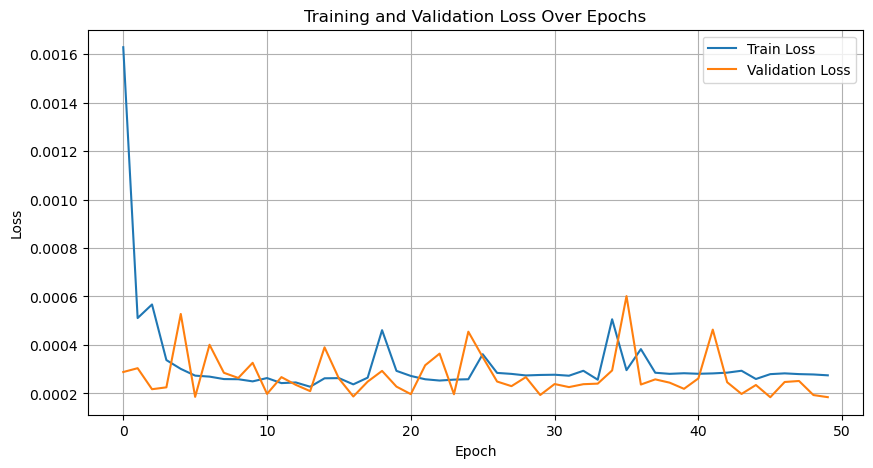

In [99]:
if not skip_training:
    # Initialize the model, loss function, and optimizer
    # best_hyperparams = {'hidden_size': 94, 'num_layers': 4, 'learning_rate': 3.5218624376812995e-05}
    hidden_size = best_hyperparams['hidden_size']
    num_layers = best_hyperparams['num_layers']
    
    EPOCHS = 50
    LEARNING_RATE = best_hyperparams['learning_rate']

    model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers)
    model.to(device).type(torch.float32)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()

    # Train and validate the model
    history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Save the model
    model_path = "soc_lstm_model.pth"
    torch.save({'model_state_dict': model.state_dict(), 'input_size': len(FEATURE_COLS)}, model_path)

### Testing

This code evaluates the performance of a trained neural network model on a test dataset for battery state-of-charge (SOC) prediction. It loads the model, computes predictions on the test set, and then calculates and prints the Mean Squared Error (MSE) and Mean Absolute Error (MAE). Additionally, it plots a scatter graph comparing the true SOC values against the predicted ones, providing a visual representation of the model's accuracy.

Mean Squared Error on Test Set:: 8.777135786478952e-06
Mean Absolute Error on Test Set: 0.0018840280498319873


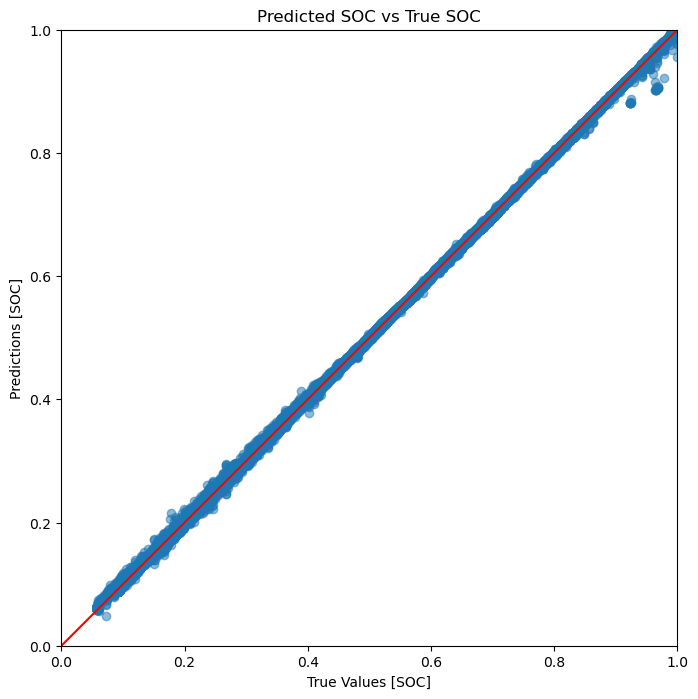

In [104]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

model_path = "soc_lstm_model.pth"
    
def load_lstm_model(model_path, input_size, hidden_size, num_layers):
    model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers).to(device).type(torch.float32)
    model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
    model.to(device)
    model.eval()
    return model

# Load and test the model
best_hyperparams = {'hidden_size': 94, 'num_layers': 4, 'learning_rate': 3.5218624376812995e-05}
hidden_size = best_hyperparams['hidden_size']
num_layers = best_hyperparams['num_layers']
loaded_model = load_lstm_model(model_path, input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers)

def test_model(model, test_loader, device):
    model.eval()
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels, _, _ in test_loader: 
            outputs = model(inputs)
            test_predictions.extend(outputs.cpu().view(-1).tolist())
            test_labels.extend(labels.cpu().view(-1).tolist())

    return test_predictions, test_labels

# Evaluate the model
test_predictions, test_labels = test_model(loaded_model, test_loader, device)

# Convert predictions and labels to numpy arrays for error calculation
test_predictions_np = np.array(test_predictions)
test_labels_np = np.array(test_labels)

# Calculate MSE and MAE
mse = mean_squared_error(test_labels_np, test_predictions_np)
mae = mean_absolute_error(test_labels_np, test_predictions_np)

print(f"Mean Squared Error on Test Set:: {mse}")
print(f"Mean Absolute Error on Test Set: {mae}")

plt.figure(figsize=(8, 8))
plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel('True Values [SOC]')
plt.ylabel('Predictions [SOC]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], color='red') 
plt.title('Predicted SOC vs True SOC')
plt.show()

### Visualization

This code block is designed to test a machine learning model's performance using a specific dataset file. It reads the test data, including voltage, current, temperature, capacity, and true SoC, then prepares the data for model prediction, excluding the time data. With the model loaded onto the device, it predicts the SoC and plots both the predicted and true SoC, along with voltage, current, temperature, and capacity over time. This visualization allows for an intuitive comparison between the model's predictions and actual measurements.

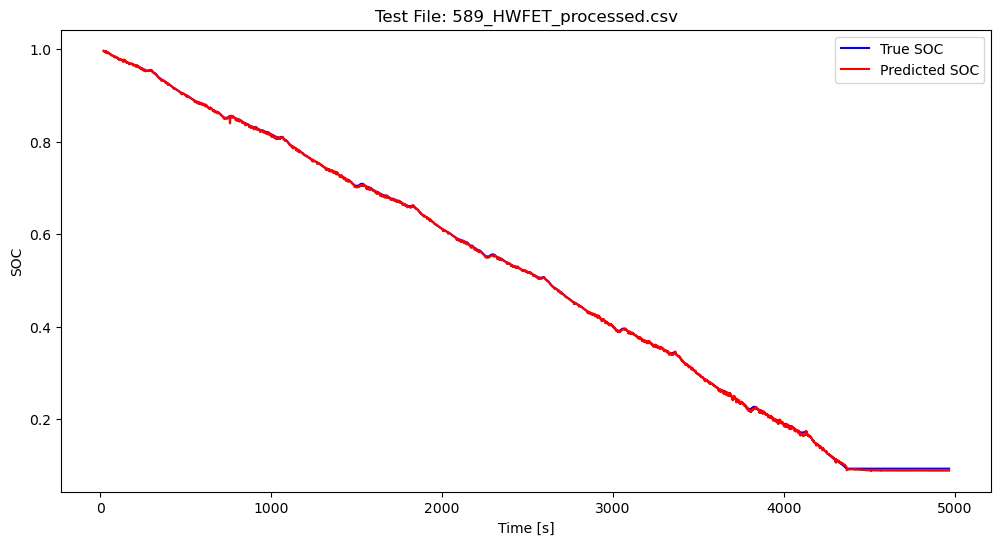

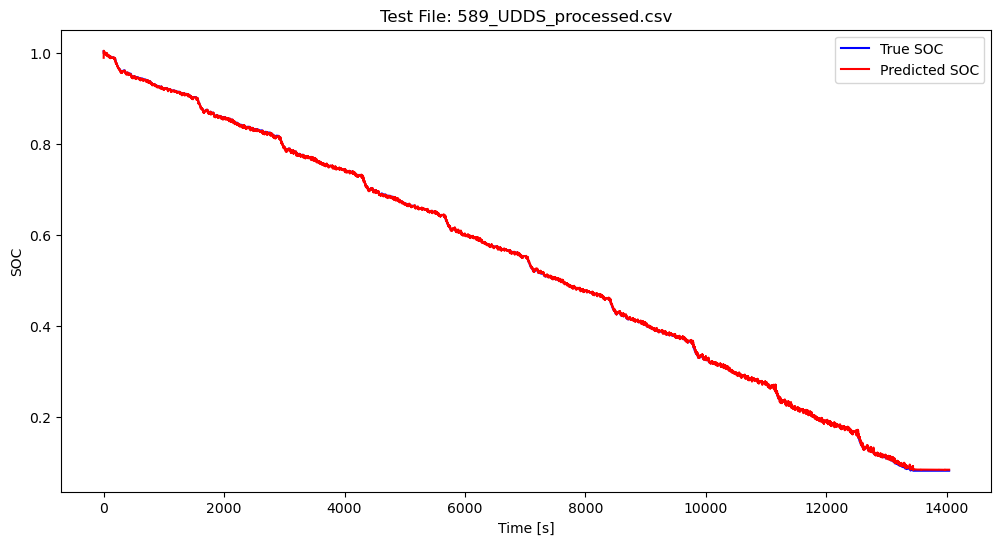

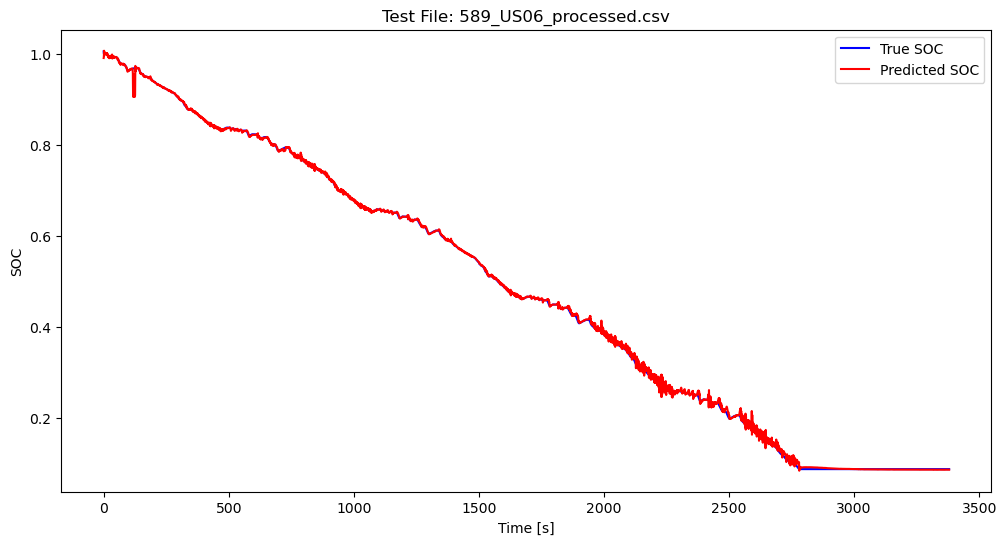

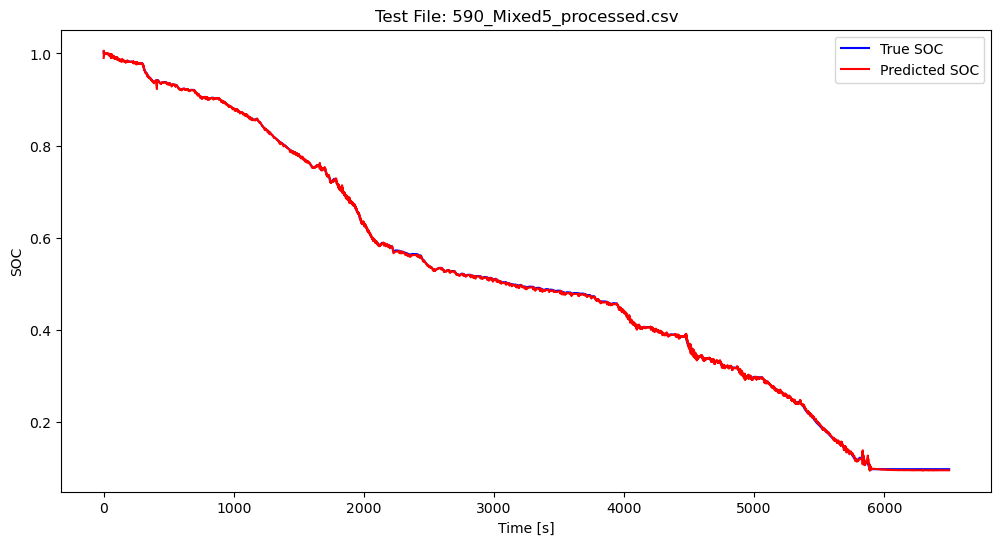

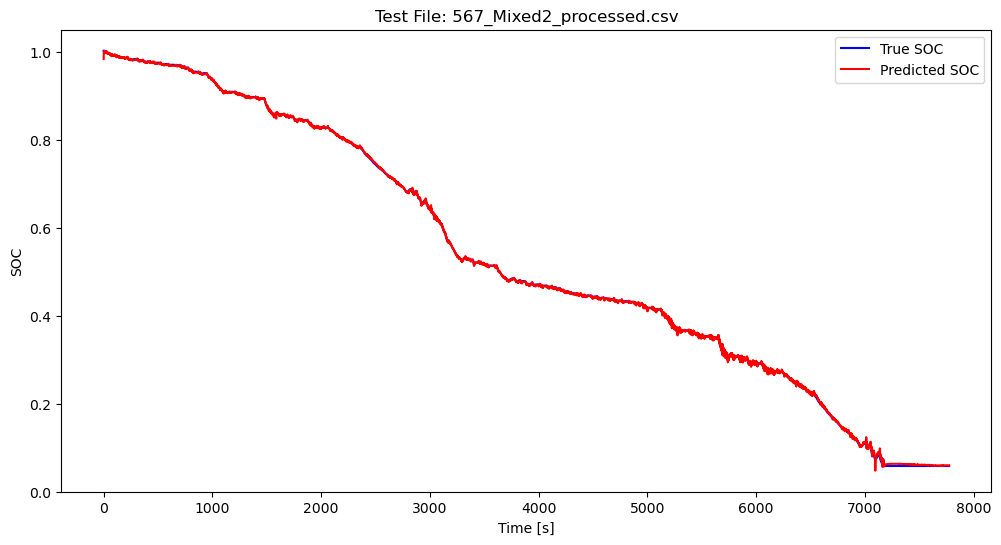

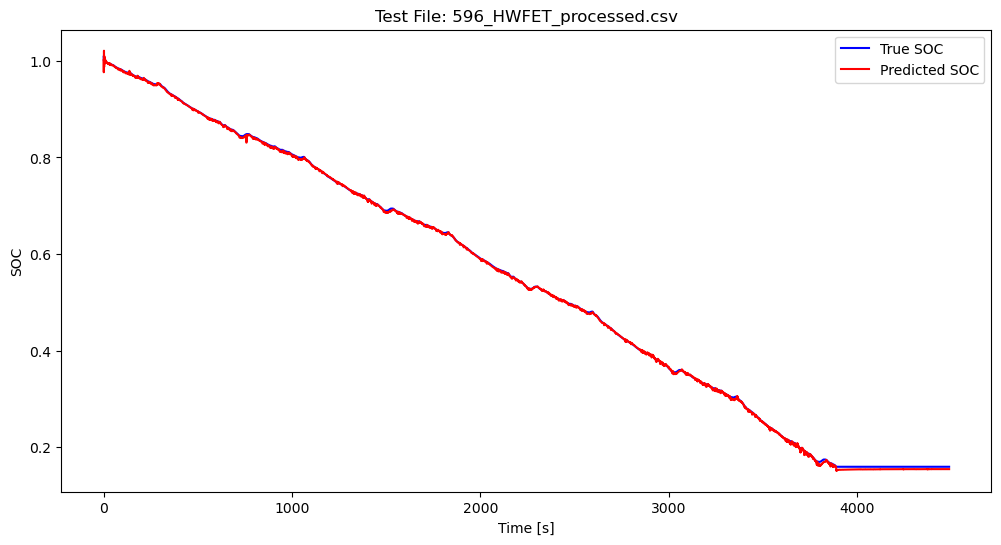

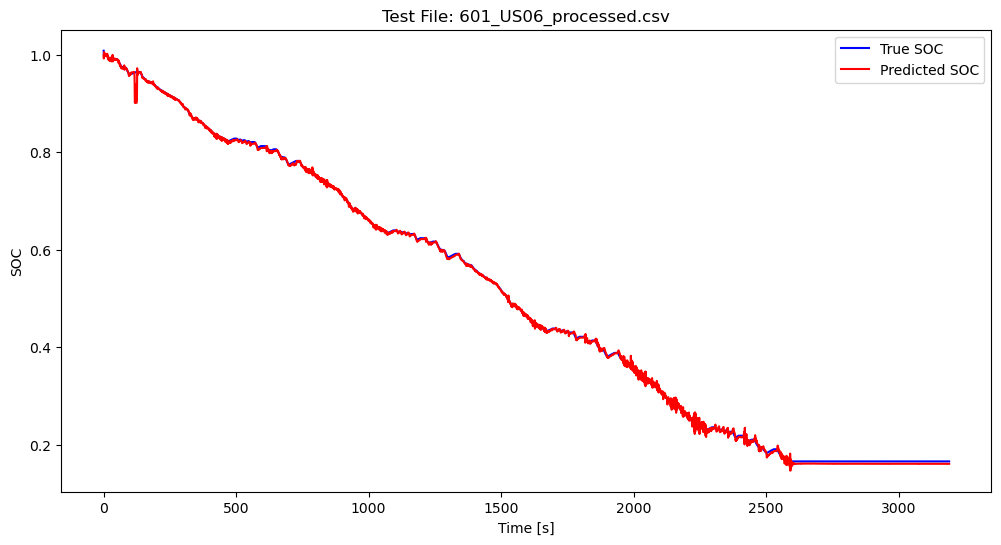

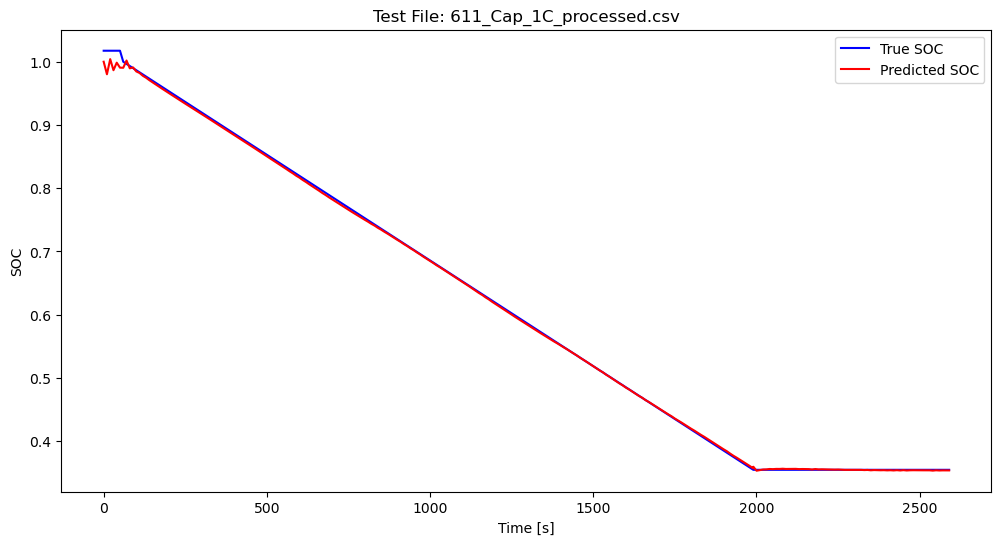

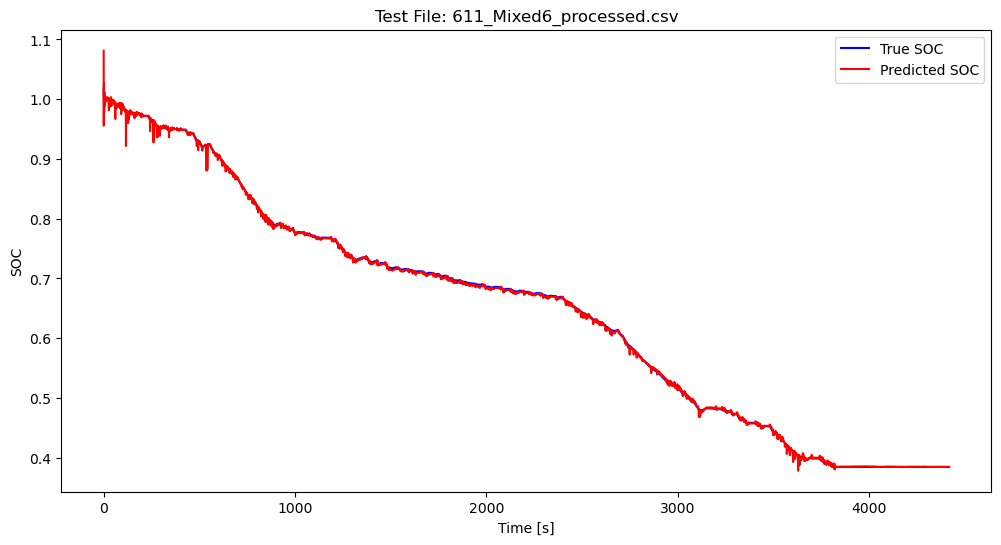

In [105]:
def test_model(model, test_loader, device):
    model.eval()
    test_results = {}

    with torch.no_grad():
        for inputs, labels, filenames, times in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = outputs.cpu().view(-1).numpy()
            labels = labels.cpu().view(-1).numpy()

            for filename, time, pred, label in zip(filenames, times, predictions, labels):
                if filename not in test_results:
                    test_results[filename] = {'times': [], 'predictions': [], 'labels': []}
                test_results[filename]['times'].append(time)
                test_results[filename]['predictions'].append(pred)
                test_results[filename]['labels'].append(label)

    return test_results

def plot_soc_over_time(test_results):
    for filename, data in test_results.items():
        times = data['times']
        predictions = data['predictions']
        labels = data['labels']

        plt.figure(figsize=(12, 6))
        plt.plot(times, labels, label='True SOC', color='blue')
        plt.plot(times, predictions, label='Predicted SOC', color='red')
        plt.title(f'Test File: {filename}')
        plt.xlabel('Time [s]')
        plt.ylabel('SOC')
        plt.legend()
        plt.show()

# Evaluate the model on the test set
test_results = test_model(loaded_model, test_loader, device)

# Plot the SOC over time for each test file
plot_soc_over_time(test_results)